In [5]:
#%%
import os
import yaml
import torch
import argparse
import models
import numpy as np
from tqdm import tqdm
from collections import Counter
from datasets import MelDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# path
os.chdir('/mnt/work/')

# config path
# data_config_path = "./Animal/configs/monkey/dataset2.yaml"
# dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
# analy_set = MelDataset(dataset_config, used_key = ['twin_1_0'], subset='test') # 
# analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# config loading
data_config_path = "./Animal/configs/monkey/dataset4.yaml" # one class
# data_config_path = "./Animal/configs/monkey/dataset1.yaml" # all class 
model_config_path = "./Animal/configs/monkey/model3.yaml"

# dataset
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
analy_set = MelDataset(dataset_config, used_key = [[
                                                      'calltype_1'
                                                      ,'calltype_2'
                                                      ,'calltype_3'
                                                    #   ,'calltype_4'
                                                    #   ,'calltype_5'
                                                      ],
                                                                  [
                                                                   'twin_1_0'
                                                                   ,'twin_1_1'
                                                                   ,'twin_2_2'
                                                                   ,'twin_2_3'
                                                                #    ,'twin_3_4'
                                                                #    ,'twin_3_5'
                                                                   ]], subset='test')


analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# device
# torch.cuda.set_device(0)
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

#load model
exp_name = 'VAEbase-class_indi1-c_10.0_0.0-i_0.1_0.0'
model_path = 'Animal/output'
save_path = os.path.join(model_path, exp_name, 'checkpoint', "100000.pth.tar")
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_z_indi_mu = []
total_z_indi_log_std = []
total_z_indi = []

total_z_con_mu = []
total_z_con_log_std = []
total_z_con = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_ctID = []
total_cID = []

for mel, lenx, indi_mel, ctID, cID in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        indi_mel = indi_mel.to(device)
        
        outputs = model(mel, lenx, indi_mel) 
        
        z_indi_mu = outputs['indi_mu'].detach().cpu().numpy()
        z_indi_log_std = outputs['indi_log_std'].detach().cpu().numpy()
        z_indi = outputs['z_indi'].detach().cpu().numpy() 
        
        z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
        z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
        z_con = outputs['z_con'].detach().cpu().numpy() 
        x_rec = outputs['x_rec'].detach().cpu().numpy() 
        
        total_z_indi_mu.append(z_indi_mu)
        total_z_indi_log_std.append(z_indi_log_std)
        total_z_indi.append(z_indi)
        total_z_con_mu.append(z_con_mu)
        total_z_con_log_std.append(z_con_log_std)
        total_z_con.append(z_con)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        total_ctID.append(ctID.detach().cpu().numpy())
        total_cID.append(cID.detach().cpu().numpy())

unique_elements, counts = np.unique(total_ctID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('ctID_counts',f"{element}: {count}")
    
unique_elements, counts = np.unique(total_cID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('cID_counts',f"{element}: {count}")
    


Dict_1 ['calltype_1', 'calltype_2', 'calltype_3']
Dict_2 ['twin_1_0', 'twin_1_1', 'twin_2_2', 'twin_2_3']


  0%|          | 0/7958 [00:00<?, ?it/s]

100%|██████████| 7958/7958 [01:21<00:00, 98.15it/s] 

ctID_counts 1: 2846
ctID_counts 2: 4921
ctID_counts 3: 191
cID_counts 0: 2833
cID_counts 1: 1641
cID_counts 2: 2429
cID_counts 3: 1055


In [6]:
used_label = total_ctID
unique_labels = np.unique(used_label)
unique_labels

array([1, 2, 3])

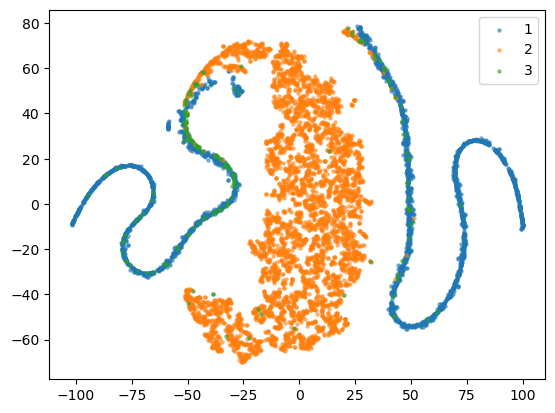

In [7]:
from sklearn.manifold import TSNE

# call type
total_z_con_1D = []
for i in total_z_con_mu: # total_z_con; content miu: total_z_con_mu; content var: total_z_con_log_std
    total_z_con_1D.append(i.sum(2))

# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components = 2, perplexity = 30, n_iter = 1000)

data_2d = tsne.fit_transform(total_z_con_1D) # cnontent

# Get unique labels
used_label = total_ctID
unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=5)

# Add a legend
plt.legend()
plt.show()

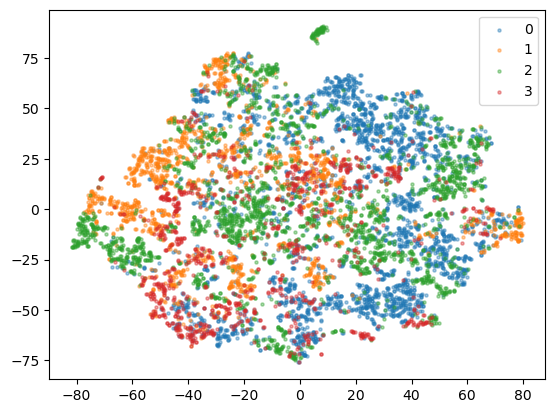

: 

In [8]:
from sklearn.manifold import TSNE

# total_z_con = 
# caller
total_z_indi = np.array(total_z_indi).squeeze() # indi
total_z_indi_mu = np.array(total_z_indi_mu).squeeze() # individual miu
total_z_indi_log_std = np.array(total_z_indi_log_std).squeeze()
total_indi = np.hstack((total_z_indi_mu, total_z_indi_log_std))

# tsne
tsne = TSNE(n_components=2, perplexity = 30, n_iter = 1000)
data_2d = tsne.fit_transform(total_z_indi_mu)

# Get unique labels
used_label = total_cID

unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.4, s=5)

# Add a legend
plt.legend()
plt.show()